In [18]:
import pandas as pd
from dataclasses import dataclass
from pelutils import log, set_seeds, DataStorage
import numpy as np
from tqdm import tqdm
import umap
import pelutils.ds.plots as plots
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans


np.set_printoptions(precision=2)

@dataclass
class Topics(DataStorage):
    ids: np.ndarray
    counts: np.ndarray
    num_words_by_id: np.ndarray


# Topic keyword frequency-based clustering
First, copy topics from the political candidate quiz

In [128]:
# https://www.dr.dk/nyheder/politik/folketingsvalg/kandidattest
topics = ("KLIMA", "ENERGI", "ARBEJDSMARKED", "ØKONOMI", "STRAF", "EU", "VELFÆRD", "UDDANNELSE", "DEMOKRATI", "SUNDHED")
assert len(topics) == len(set(topics))

parties = {
    "A": ("#a82721", "Social Democrates"),
    "Q": ("#5abe82", "Independent Greens"),
    "Ø": ("#e6801a", "Red-Green Alliance"),
    "Å": ("#2b8738", "The Alternative"),
    "O": ("#eac73e", "Danish People's Party"),
    "M": ("#b48cd2", "The Moderates"),
    "D": ("#127b7f", "New Right"),
    "Æ": ("#7896d2", "Denmark Democrats"),
    "B": ("#733280", "Danish Social Liberal Party"),
    "I": ("#3fb2be", "Liberal Alliance"),
    "C": ("#96b226", "Conservatives"),
    "F": ("#e07ea8", "Socialist People's Party"),
    "K": ("#8b8474", "Christian Democrats"),
    "V": ("#254264", "Venstre"),
    "UDEN": ("darkgrey", "No party"),
}


Run the actual keyword matching on all tweets, saving frequencies for each word.
Candidates without keyword matches are removed.
We choose to standardize frequencies to have 0 mean and a standard devation of 1 to improve convergence the dimensionality reduction algorithms and make their results comparable across often and not often used topics.

In [129]:
tp = Topics(None, None, None)
df = pd.read_csv("../data/tweets.csv")
ids = df.userID.unique()
id_to_index = { j: i for i, j in enumerate(ids) }
print("%i unique users, %i tweets" % (len(ids), len(df)))
counts = np.zeros((len(ids), len(topics)))
num_words_by_id = np.zeros(len(ids))
for _, row in tqdm(df.iterrows()):
    if isinstance(row.tweet, float):
        continue
    words = row.tweet.upper().split()
    num_words_by_id[id_to_index[row.userID]] += len(words)
    for j, topic in enumerate(topics):
        counts[id_to_index[row.userID], j] += words.count(topic)

has_words = num_words_by_id > 0
tp.ids = ids[has_words]
tp.counts = counts[has_words]
tp.num_words_by_id = num_words_by_id[has_words]

print("Removing zero data points")
tp.ids = tp.ids[~(tp.counts==0).all(axis=1)]
tp.num_words_by_id = tp.num_words_by_id[~(tp.counts==0).all(axis=1)]
tp.counts = tp.counts[~(tp.counts==0).all(axis=1)]

candidates_df = pd.read_csv("../data/candidates_with_id.csv")
party_letters = list()
names = list()

for id in tp.ids:
    try:
        candidate = candidates_df.loc[id==candidates_df.id]
        party_letters.append(candidate.Party.values[0])
        names.append(candidate.Name.values[0])
    except:
        party_letters.append("UDEN")
        names.append("Navnløs")
party_letters = np.array(party_letters)
unk_party_letters = np.array(tuple(set(party_letters)))

freq = tp.counts.copy()
for i, num_words in enumerate(tp.num_words_by_id):
    freq[i] = freq[i] / num_words
print("Standardize")
means = list()
stds = list()
for i in range(len(topics)):
    m = freq[:, i].mean()
    s = freq[:, i].std(ddof=1) + 1e-6
    means.append(m)
    stds.append(s)
    freq[:, i] = (freq[:, i] - m) / s

560 unique users, 53342 tweets


53342it [00:06, 8175.63it/s]


Run PCA on the 10-dimensional frequency vectors and visualize parti alignments.

Got embedding with shape (291, 2)


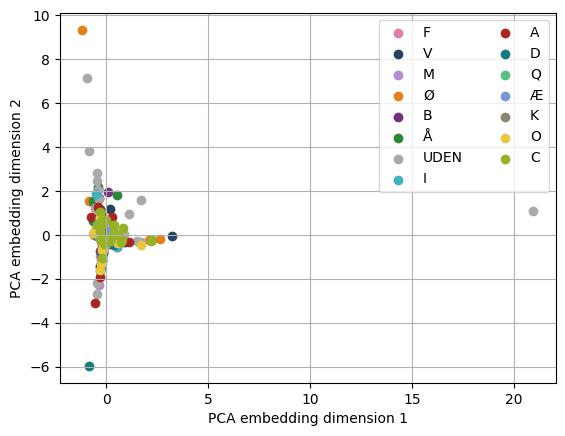

In [188]:
pca_embedding = embedding =  PCA(n_components=2).fit_transform(freq)
print("Got embedding with shape %s" % (embedding.shape,))
for letter in unk_party_letters:
    plt.scatter(embedding[party_letters==letter, 0], embedding[party_letters==letter, 1], c=parties[letter][0], label=letter)
plt.legend(ncol=2)
plt.grid()
plt.xlabel("PCA embedding dimension 1")
plt.ylabel("PCA embedding dimension 2")
plt.show()

Also use UMAP on the data

Got embedding with shape (291, 2)


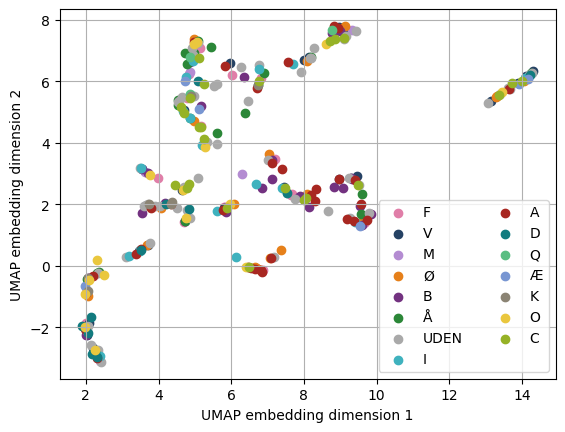

In [187]:
umap_embedding = embedding =  umap.UMAP(random_state=69).fit_transform(freq)
print("Got embedding with shape %s" % (embedding.shape,))
for letter in unk_party_letters:
    plt.scatter(embedding[party_letters==letter, 0], embedding[party_letters==letter, 1], c=parties[letter][0], label=letter)
plt.legend(ncol=2)
plt.grid()
plt.xlabel("UMAP embedding dimension 1")
plt.ylabel("UMAP embedding dimension 2")
plt.show()

Run DBScan on the UMAP embeddings as these are the only ones showing any potential to be clustered.
Use unit epsilon and a low value of min samples to work with the limited number of candidates.

In [210]:
dbscan_cluster = DBSCAN(eps=1.0, min_samples=10).fit(umap_embedding)
core_samples_mask = np.zeros_like(dbscan_cluster.labels_, dtype=bool)
core_samples_mask[dbscan_cluster.core_sample_indices_] = True
dbscan_labels = dbscan_cluster.labels_


For explainability, save top subjects for clusters + their frequencies

In [217]:
clust_texts = list()
for k in dbscan_pca_unique_labels:
    clust_topics = freq[dbscan_labels == k].mean(0)
    for i in range(clust_topics.shape[0]):
        clust_topics[i] = means[i] + clust_topics[i] * stds[i] 
    top = clust_topics.argsort()[::-1][:3]
    clust_text = "\n".join([f"{j+1}) {clust_topics[i]:.1e}: '{topics[i].lower()}'" for j, i in enumerate(top)])
    print(clust_text, "\n")
    clust_texts.append(clust_text)
    

1) 1.4e-03: 'velfærd'
2) 4.2e-05: 'energi'
3) 4.0e-05: 'demokrati' 

1) 7.8e-04: 'demokrati'
2) 4.1e-04: 'uddannelse'
3) 2.1e-04: 'eu' 

1) 2.9e-03: 'eu'
2) 4.4e-05: 'demokrati'
3) 1.9e-05: 'energi' 

1) 1.2e-03: 'sundhed'
2) 3.3e-04: 'straf'
3) 1.8e-04: 'eu' 

1) 5.1e-04: 'klima'
2) 4.3e-04: 'energi'
3) 3.4e-04: 'økonomi' 



Visualize DBscan result where big dots are core points and small dots are rim points

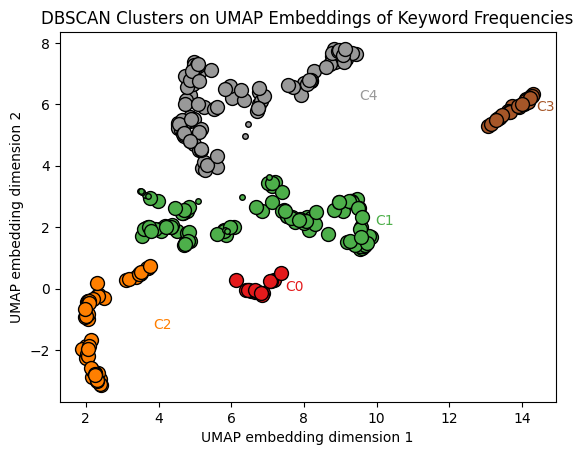

In [223]:
dbscan_pca_unique_labels = set(dbscan_labels)
n_clusters_ = len(dbscan_pca_unique_labels) - (1 if -1 in dbscan_labels else 0)


# Black removed and is used for noise instead.
colors = [plt.cm.Set1(each) for each in np.linspace(0, 1, len(dbscan_pca_unique_labels))]
for k, col in zip(dbscan_pca_unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = dbscan_labels == k

    xy = umap_embedding[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
    )
    x_text = xy[:, 0].max() + 0.1
    y_text = xy[:, 1].mean() - 0.1
    
    plt.text(
        x_text, y_text, f"C{k}", color=col
    )

    xy = umap_embedding[class_member_mask & ~ core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
    )

plt.title("DBSCAN Clusters on UMAP Embeddings of Keyword Frequencies")
plt.xlabel("UMAP embedding dimension 1")
plt.ylabel("UMAP embedding dimension 2")

plt.show()

Choose the same number of clusters as DBSCAN and check whether KMeans could have found the same grouping

In [214]:
kmeans_cluster = KMeans(n_clusters=5, random_state=0).fit(umap_embedding)
kmeans_labels = kmeans_cluster.labels_

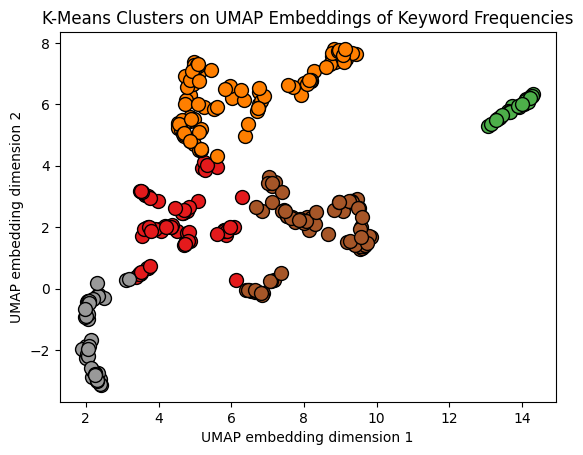

In [215]:
kmeans_pca_unique_labels = set(kmeans_labels)
n_clusters_ = len(kmeans_pca_unique_labels) - (1 if -1 in kmeans_labels else 0)


# Black removed and is used for noise instead.
colors = [plt.cm.Set1(each) for each in np.linspace(0, 1, len(dbscan_pca_unique_labels))]
for k, col in zip(kmeans_pca_unique_labels, colors):
    class_member_mask = kmeans_labels == k

    xy = umap_embedding[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
    )

plt.title("K-Means Clusters on UMAP Embeddings of Keyword Frequencies")
plt.xlabel("UMAP embedding dimension 1")
plt.ylabel("UMAP embedding dimension 2")

plt.show()

KMeans works well on exterior clusters but give an (in our opinion) less intuitive clustering of the middle points.